# HDP spell-sound analyzer

developed by Kow Kuroda (kow.kuroda@gmail.com)

This Jupyter Notebook was prepared for Kow Kuroda's paper presented at the 41st Annual Meeting of Japanese Cognitive Science Society, Tokyo (2024/10/14).

History

- 2024/08/19 Cython を使った cy_gen_ngrams を利用可能にした;
- 2024/09/02 n-gram 生成の generic function を導入し，コードを簡略化;
- 2024/09/06 term の階層クラスタリングを実装;
- 2024/10/28 (skippy) n-gram 生成処理を高速化 (Cython を使わなくてもそれなりに速くなった);
- 2024/11/23 word の文字への分割処理を改善 (diacritics が分離する可能性を抑制);
- 2025/03/01 Irish の spell-IPA symbol 対応データを追加;
- 2025/07/25 i) implemented handling of extended skippy (xsk) n-grams, ii) refactored code;

# Settings

In [1]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [2]:
check = False

In [3]:
## imports
import pprint as pp
import unicodedata

In [4]:
## 一つ上の階層のファイルを見るように設定
import os, sys
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [5]:
## 必要に応じてCython のインストール
#!conda install cython -y

In [6]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [7]:
## Cython を使うかどうか
use_Cython = False
if use_Cython:
    %load_ext Cython

In [8]:
## doc settings
doc_types        = [ 'spell', 'sound' ]
doc_type          = doc_types[0]
print(f"doc_type: {doc_type}")

## sizes
max_doc_size        = 11
min_doc_size        =  5
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

### boundary handling
mark_boundaries     = True # if True, n_for_ngram needs to be one-size bigger
print(f"mark_boundaries: {mark_boundaries}")
boundary_mark       = "#"
print(f"boundary_mark: {boundary_mark}")

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if doc_type == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")

doc_type: spell
max_doc_size: 11
min_doc_size: 5
mark_boundaries: True
boundary_mark: #
accent_status: 


In [9]:
## term settings
ngram_is_inclusive  = True
print(f"ngram_is_inclusive: {ngram_is_inclusive}")

inclusion_degree    = None
print(f"inclusion_degree: {inclusion_degree}")

ngram_is_skippy     = False
print(f"ngram_is_skippy: {ngram_is_skippy}")

skippy_means_extended = True
print(f"skippy_means_extended: {skippy_means_extended}")

ngram_is_inclusive: True
inclusion_degree: None
ngram_is_skippy: False
skippy_means_extended: True


In [10]:
n_for_ngram         = 3
print(f"n_for_ngram: {n_for_ngram}")
max_gap_ratio       = 1.0
max_gap_size        = round(max_doc_size * max_gap_ratio)
print(f"max_gap_size: {max_gap_size}")

## symbols
gap_mark            = "…"
seg_joint           = ""

## define term_type
if doc_type == 'spell':
    if ngram_is_skippy:
        if skippy_means_extended:
            term_type = f"sp_xsk{n_for_ngram}gram"
        else:
            term_type = f"sp_sk{n_for_ngram}gram"
    else:
        term_type = f"sp_{n_for_ngram}gram"
else:
    if ngram_is_skippy:
        if skippy_means_extended:
            term_type = f"sn_xsk{n_for_ngram}gram"
        else:
            term_type = f"sn_sk{n_for_ngram}gram"
    else:
        term_type = f"sn_{n_for_ngram}gram"
print(f"term_type: {term_type}")

n_for_ngram: 3
max_gap_size: 11
term_type: sp_3gram


In [11]:
## target language
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German Nouns',
                        'de_non_N_only' : 'German Non-nouns',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]

## check
target_lang_key  = target_lang_keys[11]
print(f"target_lang_key: {target_lang_key}")
print(f"target lang: {target_lang_dict[target_lang_key]} [{target_lang_key}]")

## target_attr [effective only for Irish]
target_class = ""

#target_class = None # This causes an unrediable error
if target_lang_key == "ir":
    target_classes = [ 'adjectives', 'nouns', 'verbs' ]
    target_class = f"-{target_classes[3]}"
print(f"target_class: {target_class}")

target_lang_key: es_ES
target lang: Spanish (Spain) [es_ES]
target_class: 


In [12]:
## LDA/HDP
# number of terms listed for a given topic
n_docs_to_show     = 15
n_terms_to_show    = 20
n_terms_to_save    = 120

# saving output
save_LDAvis          = False
save_topic_structure = False

# hierarchical clustering
hc_sampling_rate     = 0.02

In [13]:
## term filtering
apply_term_filtering = True

## The following parameters need to be relatively large to prevent "Row sum not equal 1" error
min_bot_size       = min_doc_size # 3
term_min_freq       = 3
print(f"term_minfreq: {term_min_freq}")

abuse_thresholds = [0.05, 0.1, 0.33, 0.5, 0.67, 0.9, 0.95]
# larger value selects shorter units, smaller value selects longer units
#abuse_threshold    = 0.05
abuse_threshold = abuse_thresholds[-1]
print(f"abuse_threshold: {abuse_threshold}")

term_minfreq: 3
abuse_threshold: 0.95


In [14]:
## sampling
source_sampling           = True
print(f"source_sampling: {source_sampling}")

source_sampling_rate      = 0.5
print(f"source_sampling_rate: {source_sampling_rate}")

source_sampling_max_size  = 2000
print(f"source_sampling_max_size: {source_sampling_max_size}")

second_sampling           = False
print(f"second_sampling: {second_sampling}")

second_sampling_rate      = 0.7
if second_sampling:
    print(f"second_sampling_rate: {second_sampling_rate}")

source_sampling: True
source_sampling_rate: 0.5
source_sampling_max_size: 2000
second_sampling: False


# Load files

In [15]:
## set target files
import glob
import pprint as pp

# intialize
target_files = [ ]
# data1
data_dir1     = "data/open-dict-ipa/data1"
target_files  = glob.glob(f"{data_dir1}/*")
# data2
data_dir2     = "data/open-dict-ipa/data1a"
target2_files = glob.glob(f"{data_dir2}/*")
target_files.extend(target2_files)
# data3
data_dir3     = "data/wn3"
extend_data_with_data3 = False
if extend_data_with_data3:
    target3_files = glob.glob(f"{data_dir3}/*")
    target_files.extend(target3_files)
# data4
data_dir4     = "data/irish"
extend_data_with_data4 = False
if extend_data_with_data4:
    target4_files = glob.glob(f"{data_dir4}/*")
    target_files.extend(target4_files)
# data5
data_dir5     = "data/custom-ipa"
extend_data_with_data5 = True
if extend_data_with_data5:
    target5_files = glob.glob(f"{data_dir5}/*")
    target_files.extend(target5_files)
#
target_files = sorted([ file for file in target_files if ".csv" in file ])
pp.pprint(target_files)

['data/custom-ipa/ir.csv',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/is.csv.gz',
 'data/open-dict-ipa/data1/ja.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/ro.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-di

In [16]:
## get source data from files
import pandas as pd
import gzip
#target_language_key = "en_US" # can be changed to get other languages
#if target_class != "" or target_class is not None:
if target_class != "":
    target_file = [ f for f in target_files if target_lang_key in f and target_class in f ][0]
else:
    target_file = [ f for f in target_files if target_lang_key in f ][0]
print(f"processing: {target_file}")
##
targets_POS = False
if target_lang_key == "ir" and targets_POS:
    col_names = ['spell', 'POS']
else:
    col_names = ['spell', 'sound']

##
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

## normalize characters
raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

## modify sound
try:
    sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
    sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
    raw_df['sound'] = sounds
except (AttributeError, KeyError):
    pass
#
raw_df.sample(10)

processing: data/open-dict-ipa/data1/es_ES.csv.gz


,spell,sound
226038,diseminarás,diseminaˈɾas
169736,desbarrigue,dezβariɣe
60166,apreciares,apɾeθjaɾes
170717,desbrozarás,dezβɾoθaˈɾas
90975,berlingado,beɾliŋgaðo
482106,rastrillare,rastɾiʎaɾe
499132,regostarte,reɣostaɾte
483505,realizándole,realiˈθandole
267849,enfurruñaba,emfuruɲaβa
199666,deslujeses,dezluxeses


In [17]:
## source sampling
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		raw_df = raw_df.sample(source_sampling_max_size)
	else:
		raw_df = raw_df.sample(round(len(raw_df) * source_sampling_rate))
## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                  spell           sound
415186    #merendillen#    #meɾendiʎen#
187365    #desengoznad#   #deseŋgoθnað#
252054     #encacharon#    #eŋkatʃaɾon#
432839     #oblicuabas#    #oβlikwaβas#
65831   #arrebolaremos#  #areβolaɾemos#
...                 ...             ...
517717     #retraeréis#    #retɾaeɾeis#
158727    #derretirían#    #deretiɾian#
240666    #embotijarán#   #embotixaɾan#
344082          #galos#         #galos#
475856      #pulsativa#     #pulsatiβa#

[2000 rows x 2 columns]


In [18]:
## generate 1-grams for spell and sound
import unicodedata
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: [*unicodedata.normalize('NFC', x)])

# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))

# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))

# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))

## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass

# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass

## check
raw_df

,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
415186,#merendillen#,#meɾendiʎen#,"[#, m, e, r, e, n, d, i, l, l, e, n, #]",13,0,0,"[#, m, e, ɾ, e, n, d, i, ʎ, e, n, #]",12
187365,#desengoznad#,#deseŋgoθnað#,"[#, d, e, s, e, n, g, o, z, n, a, d, #]",13,0,0,"[#, d, e, s, e, ŋ, g, o, θ, n, a, ð, #]",13
252054,#encacharon#,#eŋkatʃaɾon#,"[#, e, n, c, a, c, h, a, r, o, n, #]",12,0,0,"[#, e, ŋ, k, a, t, ʃ, a, ɾ, o, n, #]",12
432839,#oblicuabas#,#oβlikwaβas#,"[#, o, b, l, i, c, u, a, b, a, s, #]",12,0,0,"[#, o, β, l, i, k, w, a, β, a, s, #]",12
65831,#arrebolaremos#,#areβolaɾemos#,"[#, a, r, r, e, b, o, l, a, r, e, m, o, s, #]",15,0,0,"[#, a, r, e, β, o, l, a, ɾ, e, m, o, s, #]",14
...,...,...,...,...,...,...,...,...
517717,#retraeréis#,#retɾaeɾeis#,"[#, r, e, t, r, a, e, r, é, i, s, #]",12,0,0,"[#, r, e, t, ɾ, a, e, ɾ, e, i, s, #]",12
158727,#derretirían#,#deretiɾian#,"[#, d, e, r, r, e, t, i, r, í, a, n, #]",13,0,0,"[#, d, e, r, e, t, i, ɾ, i, a, n, #]",12
240666,#embotijarán#,#embotixaɾan#,"[#, e, m, b, o, t, i, j, a, r, á, n, #]",13,0,0,"[#, e, m, b, o, t, i, x, a, ɾ, a, n, #]",13
344082,#galos#,#galos#,"[#, g, a, l, o, s, #]",7,0,0,"[#, g, a, l, o, s, #]",7


In [19]:
## filtering raw_data by size
print(f"term_type: {term_type}")
if "sp_" in term_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_type: sp_3gram


,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
96907,#breve#,#bɾeβe#,"[#, b, r, e, v, e, #]",7,0,0,"[#, b, ɾ, e, β, e, #]",7
64009,#aridez#,#aɾiðeθ#,"[#, a, r, i, d, e, z, #]",8,0,0,"[#, a, ɾ, i, ð, e, θ, #]",8
202102,#desmigaba#,#dezmiɣaβa#,"[#, d, e, s, m, i, g, a, b, a, #]",11,0,0,"[#, d, e, z, m, i, ɣ, a, β, a, #]",11
215956,#destrence#,#destɾenθe#,"[#, d, e, s, t, r, e, n, c, e, #]",11,0,0,"[#, d, e, s, t, ɾ, e, n, θ, e, #]",11
154628,#delegaría#,#deleɣaɾia#,"[#, d, e, l, e, g, a, r, í, a, #]",11,0,0,"[#, d, e, l, e, ɣ, a, ɾ, i, a, #]",11
...,...,...,...,...,...,...,...,...
37917,#almadien#,#almaðjen#,"[#, a, l, m, a, d, i, e, n, #]",10,0,0,"[#, a, l, m, a, ð, j, e, n, #]",10
519655,#revela#,#reβela#,"[#, r, e, v, e, l, a, #]",8,0,0,"[#, r, e, β, e, l, a, #]",8
418257,#mintieren#,#mintjeɾen#,"[#, m, i, n, t, i, e, r, e, n, #]",11,0,0,"[#, m, i, n, t, j, e, ɾ, e, n, #]",11
344082,#galos#,#galos#,"[#, g, a, l, o, s, #]",7,0,0,"[#, g, a, l, o, s, #]",7


In [20]:
## define df after second sampling if any
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

742

In [21]:
## generic function for n-gram generation
def add_ngram_to_df (dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, skippy_means_extended: bool = False, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        if skippy_means_extended:
            target_var = f"{prefix}xsk{n_for_ngram}gram"
        else:
            target_var = f"{prefix}sk{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            if skippy_means_extended:
                ngrams = unigrams.apply(lambda x: cy_gen_ngrams.gen_ext_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
            else:
                ngrams = unigrams.apply(lambda x: cy_gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
            
        else:
            ngrams = unigrams.apply(lambda x: cy_gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) )
    else:
        import gen_ngrams
        if skippy:
            if skippy_means_extended:
                ngrams = unigrams.apply(lambda x: gen_ngrams.gen_ext_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
            else:
                ngrams = unigrams.apply(lambda x: gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
        else:
            ngrams = unigrams.apply(lambda x: gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) )
    ## 包括的 n-gramの生成
    if inclusive and n_for_ngram > 1:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            if skippy_means_extended:
                supplement_var = f"{prefix}xsk{n_for_ngram - 1}gram"
            else:
                supplement_var = f"{prefix}sk{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

# Spell

In [22]:
## spell n-grams
for i in range(1, n_for_ngram + 1):
    add_ngram_to_df (df, n_for_ngram = i, prefix = "sp_", seg_joint = "", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_1gram
96907                 [#, b, r, e, v, e, #]
64009              [#, a, r, i, d, e, z, #]
202102    [#, d, e, s, m, i, g, a, b, a, #]
215956    [#, d, e, s, t, r, e, n, c, e, #]
154628    [#, d, e, l, e, g, a, r, í, a, #]
                        ...                
37917        [#, a, l, m, a, d, i, e, n, #]
519655             [#, r, e, v, e, l, a, #]
418257    [#, m, i, n, t, i, e, r, e, n, #]
344082                [#, g, a, l, o, s, #]
475856    [#, p, u, l, s, a, t, i, v, a, #]
Name: sp_1gram, Length: 742, dtype: object
source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
96907         [#b, br, re, ev, ve, e#, #, b, r, e, v, e, #]
64009     [#a, ar, ri, id, de, ez, z#, #, a, r, i, d, e,...
202102    [#d, de, es, sm, mi, ig, ga, ab, ba, a#, #, d,...
215956    [#d, de, es, st, tr, re, en, nc, ce, e#, #, d,...
154628    [#d, de, el, le, eg, ga, ar, rí, ía, a#, #, d,...
                                ...                 

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_42773/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_42773/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_42773/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [23]:
## frequencies of n-grams
prefix = "sp_"
ngram_is_skippy = False
if ngram_is_skippy:
    if skippy_means_extended:
        skippiness = "xsk"
    else:
        skippiness = "sk"
else:
    skippiness = ""

most_n = 30
for i in range(1, n_for_ngram + 1): 
    var_name = f'{prefix}{skippiness}{i}gram'
    print(f"var_name: {var_name}")
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == i]) for L in df[var_name] ]

    import collections
    g = collections.Counter(G).most_common(most_n)
    print(g)

var_name: sp_1gram
[('#', 1484), ('a', 993), ('e', 613), ('r', 525), ('s', 454), ('o', 394), ('n', 354), ('i', 318), ('t', 244), ('l', 237), ('d', 223), ('c', 214), ('m', 170), ('u', 160), ('p', 133), ('b', 126), ('g', 82), ('v', 62), ('é', 55), ('f', 54), ('z', 49), ('á', 49), ('j', 45), ('h', 41), ('í', 38), ('ó', 31), ('ñ', 23), ('q', 15), ('x', 14), ('y', 13)]
var_name: sp_2gram
[('s#', 235), ('ar', 206), ('as', 144), ('a#', 129), ('#a', 127), ('re', 122), ('ra', 122), ('en', 114), ('es', 108), ('n#', 108), ('o#', 101), ('an', 95), ('ad', 91), ('#e', 88), ('ta', 80), ('la', 77), ('os', 76), ('er', 69), ('#c', 68), ('e#', 67), ('te', 60), ('ca', 58), ('#r', 57), ('na', 55), ('is', 55), ('do', 55), ('ro', 55), ('de', 54), ('ba', 52), ('#m', 52)]
var_name: sp_3gram
[('as#', 74), ('os#', 59), ('es#', 44), ('#re', 43), ('is#', 41), ('an#', 41), ('ara', 40), ('are', 39), ('en#', 38), ('#en', 38), ('do#', 37), ('#de', 35), ('ado', 33), ('ase', 31), ('aba', 30), ('des', 27), ('ará', 27), (

In [24]:
df[[ var for var in df.columns if "sp_" in var ]]

,sp_1gram,sp_size,sp_2gram,sp_3gram
96907,"[#, b, r, e, v, e, #]",7,"[#b, br, re, ev, ve, e#, #, b, r, e, v, e, #]","[#br, bre, rev, eve, ve#, #b, br, re, ev, ve, ..."
64009,"[#, a, r, i, d, e, z, #]",8,"[#a, ar, ri, id, de, ez, z#, #, a, r, i, d, e,...","[#ar, ari, rid, ide, dez, ez#, #a, ar, ri, id,..."
202102,"[#, d, e, s, m, i, g, a, b, a, #]",11,"[#d, de, es, sm, mi, ig, ga, ab, ba, a#, #, d,...","[#de, des, esm, smi, mig, iga, gab, aba, ba#, ..."
215956,"[#, d, e, s, t, r, e, n, c, e, #]",11,"[#d, de, es, st, tr, re, en, nc, ce, e#, #, d,...","[#de, des, est, str, tre, ren, enc, nce, ce#, ..."
154628,"[#, d, e, l, e, g, a, r, í, a, #]",11,"[#d, de, el, le, eg, ga, ar, rí, ía, a#, #, d,...","[#de, del, ele, leg, ega, gar, arí, ría, ía#, ..."
...,...,...,...,...
37917,"[#, a, l, m, a, d, i, e, n, #]",10,"[#a, al, lm, ma, ad, di, ie, en, n#, #, a, l, ...","[#al, alm, lma, mad, adi, die, ien, en#, #a, a..."
519655,"[#, r, e, v, e, l, a, #]",8,"[#r, re, ev, ve, el, la, a#, #, r, e, v, e, l,...","[#re, rev, eve, vel, ela, la#, #r, re, ev, ve,..."
418257,"[#, m, i, n, t, i, e, r, e, n, #]",11,"[#m, mi, in, nt, ti, ie, er, re, en, n#, #, m,...","[#mi, min, int, nti, tie, ier, ere, ren, en#, ..."
344082,"[#, g, a, l, o, s, #]",7,"[#g, ga, al, lo, os, s#, #, g, a, l, o, s, #]","[#ga, gal, alo, los, os#, #g, ga, al, lo, os, ..."


In [25]:
## spell skippy n-grams
for i in range(1, n_for_ngram + 1):
    add_ngram_to_df(df, n_for_ngram = i, prefix = "sp_", skippy = True, skippy_means_extended = skippy_means_extended, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_xsk1gram
96907                     [#…, …b…, …r…, …e…, …v…, …e…, …#]
64009                [#…, …a…, …r…, …i…, …d…, …e…, …z…, …#]
202102    [#…, …d…, …e…, …s…, …m…, …i…, …g…, …a…, …b…, …...
215956    [#…, …d…, …e…, …s…, …t…, …r…, …e…, …n…, …c…, …...
154628    [#…, …d…, …e…, …l…, …e…, …g…, …a…, …r…, …í…, …...
                                ...                        
37917      [#…, …a…, …l…, …m…, …a…, …d…, …i…, …e…, …n…, …#]
519655               [#…, …r…, …e…, …v…, …e…, …l…, …a…, …#]
418257    [#…, …m…, …i…, …n…, …t…, …i…, …e…, …r…, …e…, …...
344082                    [#…, …g…, …a…, …l…, …o…, …s…, …#]
475856    [#…, …p…, …u…, …l…, …s…, …a…, …t…, …i…, …v…, …...
Name: sp_xsk1gram, Length: 742, dtype: object
source_var: sp_1gram
target_var: sp_xsk2gram
min_size: 1
supplement_var: sp_1gram
96907     [#b…, #…r…, #…e…, #…v…, #…e…, #…#, …br…, …b…e…...
64009     [#a…, #…r…, #…i…, #…d…, #…e…, #…z…, #…#, …ar…,...
202102    [#d…, #…e…, #…s…, #…m…, #…i…, #…g…, #

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_42773/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_42773/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


min_size: 1
supplement_var: sp_xsk2gram
96907     [#…br…, #…b…e…, #…b…v…, #…b…e…, #…b…#, #…re…, ...
64009     [#…ar…, #…a…i…, #…a…d…, #…a…e…, #…a…z…, #…a…#,...
202102    [#…de…, #…d…s…, #…d…m…, #…d…i…, #…d…g…, #…d…a…...
215956    [#…de…, #…d…s…, #…d…t…, #…d…r…, #…d…e…, #…d…n…...
154628    [#…de…, #…d…l…, #…d…e…, #…d…g…, #…d…a…, #…d…r…...
                                ...                        
37917     [#…al…, #…a…m…, #…a…a…, #…a…d…, #…a…i…, #…a…e…...
519655    [#…re…, #…r…v…, #…r…e…, #…r…l…, #…r…a…, #…r…#,...
418257    [#…mi…, #…m…n…, #…m…t…, #…m…i…, #…m…e…, #…m…r…...
344082    [#…ga…, #…g…l…, #…g…o…, #…g…s…, #…g…#, #…al…, ...
475856    [#…pu…, #…p…l…, #…p…s…, #…p…a…, #…p…t…, #…p…i…...
Name: sp_xsk3gram, Length: 742, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_42773/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [26]:
## frequencies of skippy n-grams
prefix = "sp_"
ngram_is_skippy = True
if ngram_is_skippy:
    if skippy_means_extended:
        skippiness = "xsk"
    else:
        skippiness = "sk"
else:
    skippiness = ""

most_n = 30
for i in range(2, n_for_ngram + 1):
    var_name = f'{prefix}{skippiness}{i}gram'
    print(f"var_name: {var_name}")
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == i]) for L in df[var_name] ]

    import collections
    g = collections.Counter(G).most_common(most_n)
    print(g)

var_name: sp_xsk2gram
[('#…a…', 866), ('…a…#', 864), ('#…#', 742), ('…e…#', 546), ('#…e…', 525), ('…r…#', 511), ('…a…a…', 483), ('#…r…', 468), ('#…s…', 423), ('#…o…', 384), ('#…n…', 346), ('…e…a…', 333), ('…i…#', 317), ('#…i…', 303), ('…o…#', 293), ('…a…s…', 281), ('…a…e…', 268), ('…r…a…', 251), ('…n…#', 246), ('…t…#', 244), ('…l…#', 237), ('…s#', 235), ('…s…#', 219), ('…a…o…', 216), ('…c…#', 214), ('#…l…', 214), ('…ar…', 206), ('#…t…', 200), ('…d…#', 198), ('…r…s…', 189)]
var_name: sp_xsk3gram
[('#…a…#', 864), ('#…e…#', 546), ('#…r…#', 511), ('#…a…a…', 483), ('…a…r…#', 366), ('…a…a…#', 357), ('#…e…a…', 333), ('#…i…#', 317), ('…a…s#', 316), ('#…o…#', 293), ('…e…a…#', 292), ('#…a…s…', 281), ('…r…a…#', 274), ('#…a…e…', 268), ('#…r…a…', 251), ('#…n…#', 246), ('#…t…#', 244), ('#…l…#', 237), ('#…s#', 235), ('…e…r…#', 220), ('#…s…#', 219), ('#…a…o…', 216), ('#…c…#', 214), ('#…ar…', 206), ('#…d…#', 198), ('…a…e…#', 191), ('#…r…s…', 189), ('…r…e…#', 186), ('#…a…r…', 180), ('#…e…e…', 177)]


In [27]:
## frequencies of skippy n-grams
prefix = "sp_"
ngram_is_skippy = True
if ngram_is_skippy:
    if skippy_means_extended:
        skippiness = "xsk"
    else:
        skippiness = "sk"
else:
    skippiness = ""

most_n = 30
for i in range(1, n_for_ngram + 1):
    var_name = f'{prefix}{skippiness}{i}gram'
    print(f"var_name: {var_name}")
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == i]) for L in df[var_name] ]

    import collections
    g = collections.Counter(G).most_common(most_n)
    print(g)

var_name: sp_xsk1gram
[('…a…', 993), ('#…', 742), ('…#', 742), ('…e…', 613), ('…r…', 525), ('…s…', 454), ('…o…', 394), ('…n…', 354), ('…i…', 318), ('…t…', 244), ('…l…', 237), ('…d…', 223), ('…c…', 214), ('…m…', 170), ('…u…', 160), ('…p…', 133), ('…b…', 126), ('…g…', 82), ('…v…', 62), ('…é…', 55), ('…f…', 54), ('…z…', 49), ('…á…', 49), ('…j…', 45), ('…h…', 41), ('…í…', 38), ('…ó…', 31), ('…ñ…', 23), ('…q…', 15), ('…x…', 14)]
var_name: sp_xsk2gram
[('#…a…', 866), ('…a…#', 864), ('#…#', 742), ('…e…#', 546), ('#…e…', 525), ('…r…#', 511), ('…a…a…', 483), ('#…r…', 468), ('#…s…', 423), ('#…o…', 384), ('#…n…', 346), ('…e…a…', 333), ('…i…#', 317), ('#…i…', 303), ('…o…#', 293), ('…a…s…', 281), ('…a…e…', 268), ('…r…a…', 251), ('…n…#', 246), ('…t…#', 244), ('…l…#', 237), ('…s#', 235), ('…s…#', 219), ('…a…o…', 216), ('…c…#', 214), ('#…l…', 214), ('…ar…', 206), ('#…t…', 200), ('…d…#', 198), ('…r…s…', 189)]
var_name: sp_xsk3gram
[('#…a…#', 864), ('#…e…#', 546), ('#…r…#', 511), ('#…a…a…', 483), ('…a…r

In [28]:
## check result
target_vars = [ 'spell' ]
target_vars.extend([ f"sp_{i}gram" for i in range(1, n_for_ngram + 1) ])
if skippy_means_extended:
    target_vars.extend([ f"sp_xsk{i}gram" for i in range(2, n_for_ngram + 1) ])
else:
    target_vars.extend([ f"sp_sk{i}gram" for i in range(2, n_for_ngram + 1) ])
#
df[target_vars]

,spell,sp_1gram,sp_2gram,sp_3gram,sp_xsk2gram,sp_xsk3gram
96907,#breve#,"[#, b, r, e, v, e, #]","[#b, br, re, ev, ve, e#, #, b, r, e, v, e, #]","[#br, bre, rev, eve, ve#, #b, br, re, ev, ve, ...","[#b…, #…r…, #…e…, #…v…, #…e…, #…#, …br…, …b…e…...","[#…br…, #…b…e…, #…b…v…, #…b…e…, #…b…#, #…re…, ..."
64009,#aridez#,"[#, a, r, i, d, e, z, #]","[#a, ar, ri, id, de, ez, z#, #, a, r, i, d, e,...","[#ar, ari, rid, ide, dez, ez#, #a, ar, ri, id,...","[#a…, #…r…, #…i…, #…d…, #…e…, #…z…, #…#, …ar…,...","[#…ar…, #…a…i…, #…a…d…, #…a…e…, #…a…z…, #…a…#,..."
202102,#desmigaba#,"[#, d, e, s, m, i, g, a, b, a, #]","[#d, de, es, sm, mi, ig, ga, ab, ba, a#, #, d,...","[#de, des, esm, smi, mig, iga, gab, aba, ba#, ...","[#d…, #…e…, #…s…, #…m…, #…i…, #…g…, #…a…, #…b…...","[#…de…, #…d…s…, #…d…m…, #…d…i…, #…d…g…, #…d…a…..."
215956,#destrence#,"[#, d, e, s, t, r, e, n, c, e, #]","[#d, de, es, st, tr, re, en, nc, ce, e#, #, d,...","[#de, des, est, str, tre, ren, enc, nce, ce#, ...","[#d…, #…e…, #…s…, #…t…, #…r…, #…e…, #…n…, #…c…...","[#…de…, #…d…s…, #…d…t…, #…d…r…, #…d…e…, #…d…n…..."
154628,#delegaría#,"[#, d, e, l, e, g, a, r, í, a, #]","[#d, de, el, le, eg, ga, ar, rí, ía, a#, #, d,...","[#de, del, ele, leg, ega, gar, arí, ría, ía#, ...","[#d…, #…e…, #…l…, #…e…, #…g…, #…a…, #…r…, #…í…...","[#…de…, #…d…l…, #…d…e…, #…d…g…, #…d…a…, #…d…r…..."
...,...,...,...,...,...,...
37917,#almadien#,"[#, a, l, m, a, d, i, e, n, #]","[#a, al, lm, ma, ad, di, ie, en, n#, #, a, l, ...","[#al, alm, lma, mad, adi, die, ien, en#, #a, a...","[#a…, #…l…, #…m…, #…a…, #…d…, #…i…, #…e…, #…n…...","[#…al…, #…a…m…, #…a…a…, #…a…d…, #…a…i…, #…a…e…..."
519655,#revela#,"[#, r, e, v, e, l, a, #]","[#r, re, ev, ve, el, la, a#, #, r, e, v, e, l,...","[#re, rev, eve, vel, ela, la#, #r, re, ev, ve,...","[#r…, #…e…, #…v…, #…e…, #…l…, #…a…, #…#, …re…,...","[#…re…, #…r…v…, #…r…e…, #…r…l…, #…r…a…, #…r…#,..."
418257,#mintieren#,"[#, m, i, n, t, i, e, r, e, n, #]","[#m, mi, in, nt, ti, ie, er, re, en, n#, #, m,...","[#mi, min, int, nti, tie, ier, ere, ren, en#, ...","[#m…, #…i…, #…n…, #…t…, #…i…, #…e…, #…r…, #…e…...","[#…mi…, #…m…n…, #…m…t…, #…m…i…, #…m…e…, #…m…r…..."
344082,#galos#,"[#, g, a, l, o, s, #]","[#g, ga, al, lo, os, s#, #, g, a, l, o, s, #]","[#ga, gal, alo, los, os#, #g, ga, al, lo, os, ...","[#g…, #…a…, #…l…, #…o…, #…s…, #…#, …ga…, …g…l…...","[#…ga…, #…g…l…, #…g…o…, #…g…s…, #…g…#, #…al…, ..."


# Sound

In [29]:
## sound n-grams
for i in range(2, n_for_ngram + 1):
    add_ngram_to_df (df, n_for_ngram = i, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
96907         [#b, bɾ, ɾe, eβ, βe, e#, #, b, ɾ, e, β, e, #]
64009     [#a, aɾ, ɾi, ið, ðe, eθ, θ#, #, a, ɾ, i, ð, e,...
202102    [#d, de, ez, zm, mi, iɣ, ɣa, aβ, βa, a#, #, d,...
215956    [#d, de, es, st, tɾ, ɾe, en, nθ, θe, e#, #, d,...
154628    [#d, de, el, le, eɣ, ɣa, aɾ, ɾi, ia, a#, #, d,...
                                ...                        
37917     [#a, al, lm, ma, að, ðj, je, en, n#, #, a, l, ...
519655    [#r, re, eβ, βe, el, la, a#, #, r, e, β, e, l,...
418257    [#m, mi, in, nt, tj, je, eɾ, ɾe, en, n#, #, m,...
344082        [#g, ga, al, lo, os, s#, #, g, a, l, o, s, #]
475856    [#p, pu, ul, ls, sa, at, ti, iβ, βa, a#, #, p,...
Name: sn_2gram, Length: 742, dtype: object
source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram
96907     [#bɾ, bɾe, ɾeβ, eβe, βe#, #b, bɾ, ɾe, eβ, βe, ...
64009     [#aɾ, aɾi, ɾið, iðe, ðeθ, eθ#, #a, aɾ, ɾi, ið,...
202102    [#de, dez

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_42773/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_42773/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [30]:
## sound skippy n-grams
for i in range(2, n_for_ngram + 1):
    add_ngram_to_df (df, n_for_ngram = i, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk2gram
min_size: 1
supplement_var: sn_1gram
96907     [#b, #…ɾ, #…e, #…β, #…e, #…#, bɾ, b…e, b…β, b…...
64009     [#a, #…ɾ, #…i, #…ð, #…e, #…θ, #…#, aɾ, a…i, a…...
202102    [#d, #…e, #…z, #…m, #…i, #…ɣ, #…a, #…β, #…a, #...
215956    [#d, #…e, #…s, #…t, #…ɾ, #…e, #…n, #…θ, #…e, #...
154628    [#d, #…e, #…l, #…e, #…ɣ, #…a, #…ɾ, #…i, #…a, #...
                                ...                        
37917     [#a, #…l, #…m, #…a, #…ð, #…j, #…e, #…n, #…#, a...
519655    [#r, #…e, #…β, #…e, #…l, #…a, #…#, re, r…β, r…...
418257    [#m, #…i, #…n, #…t, #…j, #…e, #…ɾ, #…e, #…n, #...
344082    [#g, #…a, #…l, #…o, #…s, #…#, ga, g…l, g…o, g…...
475856    [#p, #…u, #…l, #…s, #…a, #…t, #…i, #…β, #…a, #...
Name: sn_sk2gram, Length: 742, dtype: object
source_var: sn_1gram
target_var: sn_sk3gram
min_size: 1
supplement_var: sn_sk2gram
96907     [#bɾ, #b…e, #b…β, #b…e, #b…#, #…ɾe, #…ɾ…β, #…ɾ...
64009     [#aɾ, #a…i, #a…ð, #a…e, #a…θ, #a…#, #…ɾi, #…ɾ…...
202102    [

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_42773/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams
/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_42773/4116675474.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [31]:
## check result
dropped_vars = [ 'sp_size', 'hyphen', 'period', 'sn_size' ]
if doc_type == 'spell':
    extra = [ 'sn_1gram', 'sn_2gram', 'sn_3gram', 'sn_4gram',
             'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]
else:
    extra = [ 'sp_1gram', 'sp_2gram', 'sp_3gram', 'sp_4gram',
             'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]    
#
df[target_vars]

,spell,sound,sp_1gram,sp_2gram,sp_3gram,sp_xsk1gram,sp_xsk2gram,sp_xsk3gram
96907,#breve#,#bɾeβe#,"[#, b, r, e, v, e, #]","[#b, br, re, ev, ve, e#, #, b, r, e, v, e, #]","[#br, bre, rev, eve, ve#, #b, br, re, ev, ve, ...","[#…, …b…, …r…, …e…, …v…, …e…, …#]","[#b…, #…r…, #…e…, #…v…, #…e…, #…#, …br…, …b…e…...","[#…br…, #…b…e…, #…b…v…, #…b…e…, #…b…#, #…re…, ..."
64009,#aridez#,#aɾiðeθ#,"[#, a, r, i, d, e, z, #]","[#a, ar, ri, id, de, ez, z#, #, a, r, i, d, e,...","[#ar, ari, rid, ide, dez, ez#, #a, ar, ri, id,...","[#…, …a…, …r…, …i…, …d…, …e…, …z…, …#]","[#a…, #…r…, #…i…, #…d…, #…e…, #…z…, #…#, …ar…,...","[#…ar…, #…a…i…, #…a…d…, #…a…e…, #…a…z…, #…a…#,..."
202102,#desmigaba#,#dezmiɣaβa#,"[#, d, e, s, m, i, g, a, b, a, #]","[#d, de, es, sm, mi, ig, ga, ab, ba, a#, #, d,...","[#de, des, esm, smi, mig, iga, gab, aba, ba#, ...","[#…, …d…, …e…, …s…, …m…, …i…, …g…, …a…, …b…, …...","[#d…, #…e…, #…s…, #…m…, #…i…, #…g…, #…a…, #…b…...","[#…de…, #…d…s…, #…d…m…, #…d…i…, #…d…g…, #…d…a…..."
215956,#destrence#,#destɾenθe#,"[#, d, e, s, t, r, e, n, c, e, #]","[#d, de, es, st, tr, re, en, nc, ce, e#, #, d,...","[#de, des, est, str, tre, ren, enc, nce, ce#, ...","[#…, …d…, …e…, …s…, …t…, …r…, …e…, …n…, …c…, …...","[#d…, #…e…, #…s…, #…t…, #…r…, #…e…, #…n…, #…c…...","[#…de…, #…d…s…, #…d…t…, #…d…r…, #…d…e…, #…d…n…..."
154628,#delegaría#,#deleɣaɾia#,"[#, d, e, l, e, g, a, r, í, a, #]","[#d, de, el, le, eg, ga, ar, rí, ía, a#, #, d,...","[#de, del, ele, leg, ega, gar, arí, ría, ía#, ...","[#…, …d…, …e…, …l…, …e…, …g…, …a…, …r…, …í…, …...","[#d…, #…e…, #…l…, #…e…, #…g…, #…a…, #…r…, #…í…...","[#…de…, #…d…l…, #…d…e…, #…d…g…, #…d…a…, #…d…r…..."
...,...,...,...,...,...,...,...,...
37917,#almadien#,#almaðjen#,"[#, a, l, m, a, d, i, e, n, #]","[#a, al, lm, ma, ad, di, ie, en, n#, #, a, l, ...","[#al, alm, lma, mad, adi, die, ien, en#, #a, a...","[#…, …a…, …l…, …m…, …a…, …d…, …i…, …e…, …n…, …#]","[#a…, #…l…, #…m…, #…a…, #…d…, #…i…, #…e…, #…n…...","[#…al…, #…a…m…, #…a…a…, #…a…d…, #…a…i…, #…a…e…..."
519655,#revela#,#reβela#,"[#, r, e, v, e, l, a, #]","[#r, re, ev, ve, el, la, a#, #, r, e, v, e, l,...","[#re, rev, eve, vel, ela, la#, #r, re, ev, ve,...","[#…, …r…, …e…, …v…, …e…, …l…, …a…, …#]","[#r…, #…e…, #…v…, #…e…, #…l…, #…a…, #…#, …re…,...","[#…re…, #…r…v…, #…r…e…, #…r…l…, #…r…a…, #…r…#,..."
418257,#mintieren#,#mintjeɾen#,"[#, m, i, n, t, i, e, r, e, n, #]","[#m, mi, in, nt, ti, ie, er, re, en, n#, #, m,...","[#mi, min, int, nti, tie, ier, ere, ren, en#, ...","[#…, …m…, …i…, …n…, …t…, …i…, …e…, …r…, …e…, …...","[#m…, #…i…, #…n…, #…t…, #…i…, #…e…, #…r…, #…e…...","[#…mi…, #…m…n…, #…m…t…, #…m…i…, #…m…e…, #…m…r…..."
344082,#galos#,#galos#,"[#, g, a, l, o, s, #]","[#g, ga, al, lo, os, s#, #, g, a, l, o, s, #]","[#ga, gal, alo, los, os#, #g, ga, al, lo, os, ...","[#…, …g…, …a…, …l…, …o…, …s…, …#]","[#g…, #…a…, #…l…, #…o…, #…s…, #…#, …ga…, …g…l…...","[#…ga…, #…g…l…, #…g…o…, #…g…s…, #…g…#, #…al…, ..."


# Analysis

In [32]:
#import matplotlib
#matplotlib.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

In [33]:
#import HDP_utils

In [34]:
## select data type and define doc_dict
import random
if "sp_" in term_type:
    base_type = "spell"
else:
    base_type = "sound"
doc_dict = { i: x for i, x in enumerate(df[base_type]) }
## check
random.sample(doc_dict.items(), 10)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_42773/1181347170.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(doc_dict.items(), 10)


[(100, '#anidian#'),
 (225, '#abuzó#'),
 (598, '#cuña#'),
 (221, '#lepare#'),
 (331, '#jorca#'),
 (649, '#encante#'),
 (615, '#calavereó#'),
 (96, '#peinare#'),
 (357, '#encismase#'),
 (620, '#zapallo#')]

In [35]:
## select bots for analysis
enable_term_change = False # if you want to change term_type to save time and energy
if enable_term_change:
	term_type = 'sp_sk4gram'
	print(f"(changed) term_type: {term_type}")

## bot stands for 'bag-of-terms', a generalization of 'bag-of-words'
bots = [ x for x in df[term_type] if len(x) > min_bot_size ] # Crucially

In [36]:
if check:
	import random
	random.sample(bots, 1)

In [37]:
## generate dictionary
from gensim.corpora import Dictionary
diction = Dictionary(bots)
print(diction)

#apply_term_filtering = False
if apply_term_filtering:
    print(f"term filtering applied")
    diction.filter_extremes(no_below = term_min_freq, no_above = abuse_threshold)
else:
    print(f"term filtering not applied")
## check
print(diction)

## generate DTM
corpus = [ diction.doc2bow(bot) for bot in bots if len(bot) >= min_bot_size ] # Crucially

Dictionary<2217 unique tokens: ['#', '#b', '#br', 'b', 'br']...>
term filtering applied
Dictionary<892 unique tokens: ['#b', '#br', 'b', 'br', 'bre']...>


In [38]:
## sanitize corpus: HDP の場合は必須の処理
corpus = [ doc for doc in corpus if len(doc) > 0 ] # filter out empty rows 

In [39]:
## HDP (n_topics = 15)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 15
hdp15 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data15 = pyLDAvis.gensim.prepare(hdp15, corpus, diction)
pyLDAvis.display(vis_data15)

In [40]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data15, vis_output)

In [41]:
## import helper functions
import numpy as np
import HDP_helper
reload_module = True
if reload_module:
    import importlib
    importlib.reload(HDP_helper)

In [42]:
## topic investigation
target_hdp = hdp15
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.007 * ac + 0.007 * sac + 0.006 * to + 0.006 * #ar + 0.005 * ría + 0.005 * nea + 0.005 * aré + 0.005 * x + 0.005 * mar + 0.005 * aju + 0.005 * ugu + 0.005 * bu + 0.005 * hu + 0.004 * ota + 0.004 * eso + 0.004 * i + 0.004 * mu + 0.004 * te# + 0.004 * b + 0.004 * ás
nonzero count:  46
	0.7477: #cálibe#
	0.5736: #jorobáis#
	0.5117: #abovedad#
	0.4227: #volqueó#
	0.4101: #abuzó#
	0.4080: #acentuad#
	0.3762: #acobardo#
	0.3580: #jijearían#
	0.3423: #olvidaré#
	0.3382: #culito#
	0.3191: #bastanteé#
	0.3025: #cohibís#
	0.3001: #ballestee#
	0.2988: #acotaría#
	0.2864: #odiando#
topic_id 1: 0.007 * ul + 0.007 * oto + 0.006 * ena + 0.006 * mot + 0.006 * #i + 0.005 * va# + 0.005 * epa + 0.005 * scu + 0.005 * eri + 0.005 * ecu + 0.005 * vab + 0.005 * #mi + 0.005 * he + 0.005 * aré + 0.005 * éi + 0.005 * cl + 0.004 * vil + 0.004 * far + 0.004 * gas + 0.004 * #ro
nonzero count:  78
	0.9572: #legislen#
	0.9446: #ergios#
	0.6900: #esquilero#
	0.6875: #teósofos#
	0.6571: #culón#
	0.6519: #

In [43]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp15.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp15_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp15_topics_out, header = False, index = None)
    print(f"saved: {hdp15_topics_out}")

892 rows remain after density filtering, discarding 0 rows
580 rows remain after size filtering, discarding 312 rows
58 rows remain after size filtering, discarding 522 rows


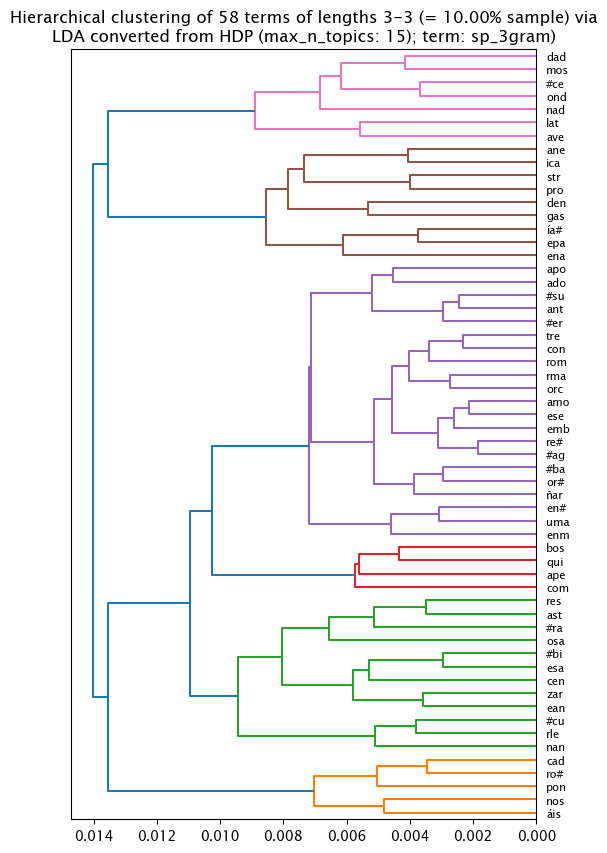

In [44]:
## term の階層クラスタリング
## max_n_topics の値に拠ってparameters の最適値 (特に lowest_density) は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp15, diction, term_type = term_type, n_topics= 15, lowest_density = 0.00001, max_length = n_for_ngram, min_length = 3, sampling_rate = 0.1, gap_mark = gap_mark, use_CJK = False, check = False)

In [45]:
## HDP (n_topics = 45)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 45
hdp45 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data45 = pyLDAvis.gensim.prepare(hdp45, corpus, diction)
pyLDAvis.display(vis_data45)

In [46]:
## save LDAvis output as a html file
lang_dir_name = target_lang_dict[target_lang_key].split()[0]
#save_LDAvis = True
if save_LDAvis:
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data45, vis_output)

In [47]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp45.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    #hdp45_topics_out = f"results/terms-by-topics-raw/hdp{max_n_topics}_topics_raw.csv"
    hdp45_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv (hdp45_topics_out, header = False, index = None)
    print(f"saved: {hdp45_topics_out}")

In [48]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp45
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob
#
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: {len(probs.nonzero()[0])}")
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.008 * ba + 0.008 * rap + 0.008 * #za + 0.007 * ub + 0.007 * ñe + 0.007 * ere + 0.006 * mba + 0.006 * cia + 0.006 * o + 0.006 * pel + 0.005 * #v + 0.005 * ye + 0.005 * ari + 0.005 * #cu + 0.005 * sal + 0.005 * to# + 0.005 * lle + 0.005 * cl + 0.005 * len + 0.005 * irl
nonzero count: 53
	0.6303: #colegida#
	0.5634: #alboroto#
	0.5561: #dalmático#
	0.4826: #chorrada#
	0.4804: #papaíto#
	0.4766: #porrazos#
	0.4642: #fingidor#
	0.4469: #reboto#
	0.4293: #zapallo#
	0.4261: #paliaba#
	0.4226: #gusarapo#
	0.4180: #apoye#
	0.4097: #confinado#
	0.4072: #confiado#
	0.4028: #todo#
topic_id 1: 0.009 * #pu + 0.009 * rri + 0.007 * sco + 0.006 * abo + 0.006 * art + 0.006 * epa + 0.005 * #m + 0.005 * mbr + 0.005 * rd + 0.005 * rv + 0.005 * jo + 0.005 * esm + 0.005 * ida + 0.005 * br + 0.005 * ar + 0.004 * do# + 0.004 * ras + 0.004 * ias + 0.004 * eé# + 0.004 * zo#
nonzero count: 58
	0.7421: #bacheado#
	0.7234: #acobardo#
	0.7159: #soplado#
	0.6968: #alomando#
	0.6640: #empalado#
	0.6605: 

892 rows remain after density filtering, discarding 0 rows
862 rows remain after size filtering, discarding 30 rows
86 rows remain after size filtering, discarding 776 rows


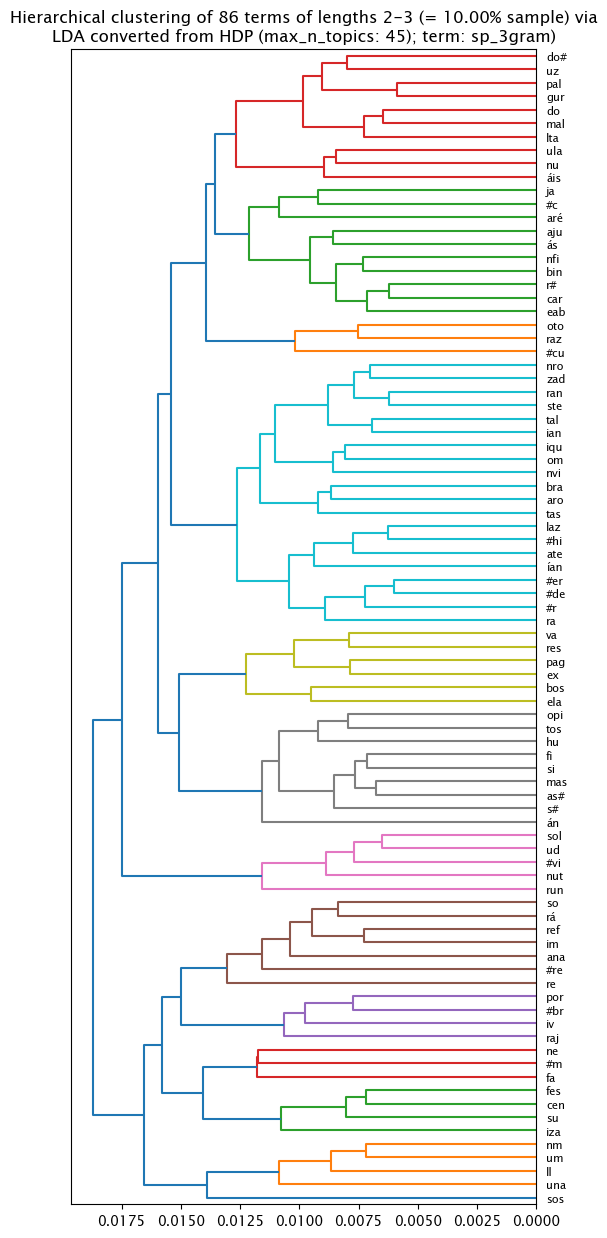

In [49]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp45, diction, term_type = term_type, n_topics = 45, lowest_density = 0.0003, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = 0.1, check = False)

In [50]:
## HDP (n_topics = 90)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 90
hdp90 = gensim.models.HdpModel(corpus, diction, T = max_n_topics,
                               random_state = 1)
vis_data90 = pyLDAvis.gensim.prepare(hdp90, corpus, diction)
pyLDAvis.display(vis_data90)

In [51]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data90, vis_output)

In [52]:
## save topic structures
if save_topic_structure:
    hdp_topics = hdp90.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }

    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp90_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp90_topics_out, header = False, index = None)
    print(f"saved: {hdp90_topics_out}")

In [53]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp90
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.009 * #pu + 0.009 * rri + 0.007 * sco + 0.006 * abo + 0.006 * art + 0.006 * epa + 0.005 * #m + 0.005 * mbr + 0.005 * rd + 0.005 * rv + 0.005 * jo + 0.005 * esm + 0.005 * ida + 0.005 * br + 0.005 * ar + 0.005 * do# + 0.004 * m + 0.004 * ias + 0.004 * ras + 0.004 * eé#
nonzero count:  42
	0.7838: #bacheado#
	0.7423: #soplado#
	0.7076: #desmigaba#
	0.6848: #empalado#
	0.6428: #parlona#
	0.6353: #enlomado#
	0.6217: #ululado#
	0.5937: #acobardo#
	0.5614: #alomando#
	0.5010: #sajumaya#
	0.4991: #deparar#
	0.4945: #mutado#
	0.4888: #embalados#
	0.4661: #multando#
	0.4482: #mimbra#
topic_id 1: 0.008 * re + 0.007 * ñ + 0.007 * ito + 0.006 * a + 0.006 * ve + 0.006 * cad + 0.006 * #ag + 0.005 * ord + 0.005 * la# + 0.005 * hi + 0.005 * ca + 0.005 * cea + 0.005 * nl + 0.005 * ás# + 0.005 * ode + 0.005 * #m + 0.005 * ev + 0.005 * lad + 0.005 * ut + 0.005 * tes
nonzero count:  134
	0.9462: #revela#
	0.7964: #cicatería#
	0.7745: #binaran#
	0.7431: #recatean#
	0.7015: #cablearán#
	0.6935:

892 rows remain after density filtering, discarding 0 rows
862 rows remain after size filtering, discarding 30 rows
86 rows remain after size filtering, discarding 776 rows


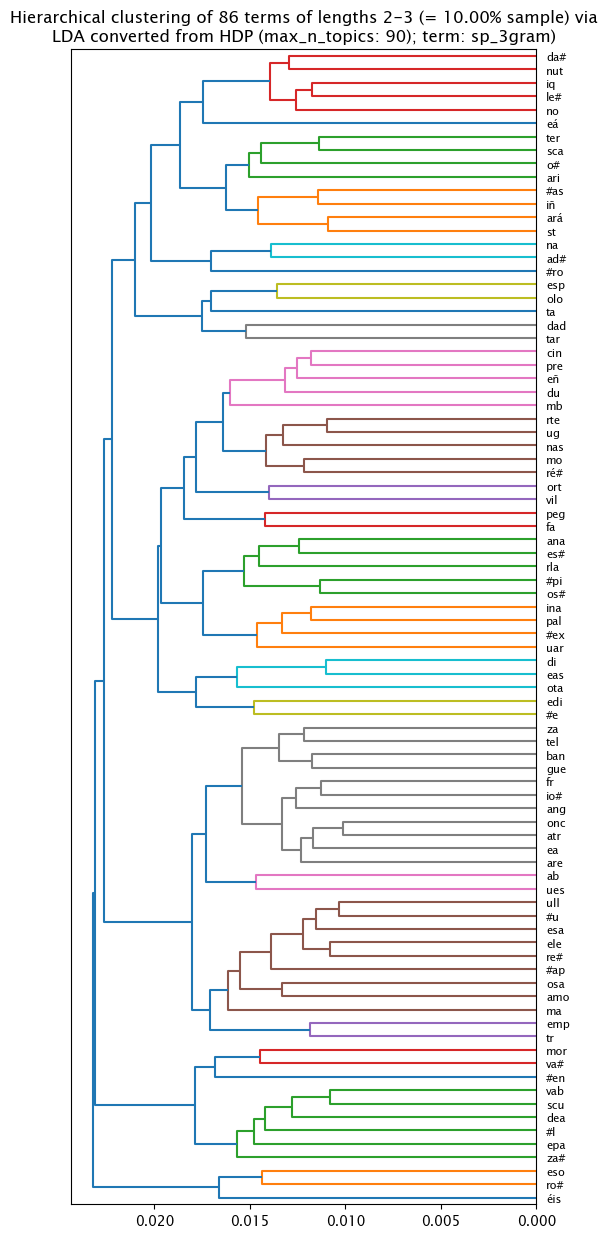

In [54]:
## term の階層クラスタリング: max_n_topics, term の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp90, diction, term_type = term_type, n_topics = 90, lowest_density = 0.0012, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = 0.1, check = False)